### **Simple Greeting Chatbot **

In [0]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

In [23]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download en_core_web_md;
!{python} -m spacy link --force en_core_web_md en;

Requirement already up-to-date: rasa_core==0.9.0a7 in /usr/local/lib/python3.6/dist-packages (0.9.0a7)
Requirement already up-to-date: rasa_nlu[spacy] in /usr/local/lib/python3.6/dist-packages (0.14.5)
  Using cached https://files.pythonhosted.org/packages/f9/c8/8db4108aba5e2166cd2ea4eafa1a4b82f89240a1fa85733029cc2358ad1f/scikit_learn-0.19.2-cp36-cp36m-manylinux1_x86_64.whl
yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
rasa-nlu 0.14.5 has requirement future~=0.17.1, but you'll have future 0.16.0 which is incompatible.
rasa-nlu 0.14.5 has requirement requests~=2.20, but you'll have requests 2.18.4 which is incompatible.
rasa-nlu 0.14.5 has requirement scikit-learn~=0.20.2, but you'll have scikit-learn 0.19.2 which is incompatible.
rasa-core 0.9.0a7 has requirement rasa-nlu~=0.12.0, but you'll have rasa-nlu 0.14.5 which is incompatible.
imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-lear

Let's check if the correct versions are installed (should be rasa_nlu: 0.12.3 rasa_core: 0.9.0a7) and the spacy model is available:

In [24]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.14.5 rasa_core: 0.9.0a7
Loading spaCy language model...
Hello world!


In [25]:
!git clone https://github.com/Homebrew/linuxbrew.git ~/.linuxbrew

fatal: destination path '/root/.linuxbrew' already exists and is not an empty directory.


In [0]:
!export PATH="$HOME/.linuxbrew/bin:$PATH"
!export MANPATH="$HOME/.linuxbrew/share/man:$MANPATH"
!export INFOPATH="$HOME/.linuxbrew/share/info:$INFOPATH"

### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

Try installing with anyone of these (or adapt to your operating system):

In [27]:


!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
!brew install graphviz;

/bin/bash: brew: command not found


and another python package and we are ready to go:

In [28]:
!{python} -m pip install pygraphviz;

In [29]:
pip install -U scikit-learn 

  Using cached https://files.pythonhosted.org/packages/5e/82/c0de5839d613b82bddd088599ac0bbfbbbcbd8ca470680658352d2c435bd/scikit_learn-0.20.3-cp36-cp36m-manylinux1_x86_64.whl
rasa-nlu 0.14.5 has requirement future~=0.17.1, but you'll have future 0.16.0 which is incompatible.
rasa-nlu 0.14.5 has requirement requests~=2.20, but you'll have requests 2.18.4 which is incompatible.
rasa-core 0.9.0a7 has requirement rasa-nlu~=0.12.0, but you'll have rasa-nlu 0.14.5 which is incompatible.
rasa-core 0.9.0a7 has requirement scikit-learn~=0.19.0, but you'll have scikit-learn 0.20.3 which is incompatible.
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


## Part 1: Add natural language understanding

First thing our bot is going to learn is how to understand user messages. To do that, you're going to build a first version of your language understanding model with Rasa NLU. 

### Language Understanding


Lets create some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. [More information about the data format](https://nlu.rasa.com/dataformat.html#markdown-format). This is the training data for our NLU model, one example per line. Entities are labeled using the markdown link syntex: `[entity value](entity_type)`:

In [30]:
nlu_md = """
## intent:greet
- hey I am [Peter](PERSON)
- hello there I am [Hans](PERSON)
- hi I am [Tom](PERSON)
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- so sad
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


To properly train your NLU model, you also need to define what is part of that model. Rasa NLU uses a similar pipeline concept as sklearn does. All the components that are listed in the pipeline will be trained one after another and everyone of them contributes its part to the structured data extraction:

In [31]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Train the Rasa NLU Model

You're going to train a model to recognise these intents, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [32]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
#model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

model_directory = trainer.persist("./", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- Found intents: 'mood_unhappy', 'mood_affirm', 'mood_great', 'greet', 'mood_deny', 'goodbye'
	- entity examples: 3 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train componen

Fitting 2 folds for each of 6 candidates, totalling 12 fits


INFO:rasa_nlu.model:Successfully saved model into '/content/default/current'


In [33]:
import sklearn
print(sklearn.__version__)

0.20.3


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

In [34]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- Found intents: 'mood_unhappy', 'mood_affirm', 'mood_great', 'greet', 'mood_deny', 'goodbye'
	- entity examples: 3 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 68 examples that have a defined intent out of 68 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9852163087457204
INFO:rasa_nlu.evaluate:Precision: 0.986344537815126
INFO:rasa_nlu.evaluate:Accuracy:  0.9852941176470589
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

     goodbye       1.00      0.91      0.95        11
       greet       0.93      1.00      0.96        13
 mood_affirm       1.00    

{'entity_evaluation': {'ner_spacy': {'accuracy': 0.9433962264150944,
   'f1_score': 0.970857463104801,
   'precision': 1.0,
   'report': '              precision    recall  f1-score   support\n\n        DATE       0.00      0.00      0.00         0\n      PERSON       1.00      1.00      1.00         3\n        TIME       0.00      0.00      0.00         0\n   no_entity       1.00      0.94      0.97       156\n\n   micro avg       0.94      0.94      0.94       159\n   macro avg       0.50      0.49      0.49       159\nweighted avg       1.00      0.94      0.97       159\n'}},
 'intent_evaluation': {'accuracy': 0.9852941176470589,
  'f1_score': 0.9852163087457204,
  'precision': 0.986344537815126,
  'predictions': [{'confidence': 0.5507236299177471,
    'intent': 'greet',
    'predicted': 'greet',
    'text': 'hey I am Peter'},
   {'confidence': 0.5224194978570833,
    'intent': 'greet',
    'predicted': 'greet',
    'text': 'hello there I am Hans'},
   {'confidence': 0.542200361045

# Part 2: Adding dialogue capabilities

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [35]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [36]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy

slots:
  img_api_response:
    type: unfeaturized

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up: {img_api_response}"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom API methods

Sometimes, you not only want to send back messages to the user, but you also want to call an API or run some code. YOu can create custom actions that will be called once the bots ML model predicts them. You'll use that to fetch a random image from a remote server (we are not actually fetching it here, but we could ;)

In [0]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import requests

class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        dispatcher.utter_message("looking for a good img")
        url = "https://picsum.photos/200/300/?random"
        return [SlotSet("img_api_response", url)]  

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 219.72it/s, # trackers=1]


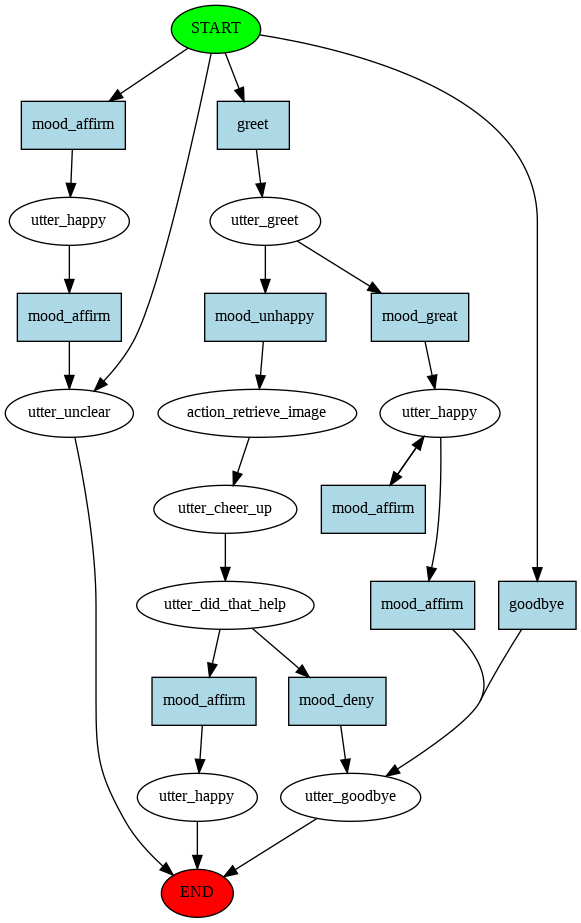

In [38]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [39]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 70.87it/s, # trackers=20]
Processed actions: 161it [00:00, 249.46it/s, # examples=161]
INFO:rasa_core.policies.memoization:Memorized 161 unique action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 161 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 5, 15)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
161/161 [==============================] - 1s 7ms/step - loss: 2.1167 - acc: 0.3168
Epoch 2/400
161/161 [==============================] - 0s 312us/step - loss: 2.0453 - acc: 0.4783
Epoch 3/400
161/161 [==============================] - 0s 311us/step - loss: 1

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [40]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [41]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Your bot is ready to talk! Type your messages here or send 'stop'
hello
Hey! How are you?
i am feeling good
Great carry on!
how are you ?
Great carry on!
i am sad
Bye
i am excited 
I am not sure what you are aiming for.
bye
I am not sure what you are aiming for.
good bye
I am not sure what you are aiming for.
good morning
I am not sure what you are aiming for.
see you 
I am not sure what you are aiming for.
bye bye
I am not sure what you are aiming for.
how are you 
I am not sure what you are aiming for.
great
Great carry on!
sad
I am not sure what you are aiming for.
gloomy
I am not sure what you are aiming for.
stop
